# Loading the data and basic EDA

In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [527]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_updated.csv")
poi = pd.read_csv("poi.csv")
#data = train + test
data = pd.concat((train, test)).reset_index(drop = True)
data.drop(['price'], axis=1, inplace=True)
data.head()

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,10461,True,Buono stato / Abitabile,1980.0,41.901300,12.700000,175.00,30.0,2.0,NaN,1.0,NaN,3.0,1.0,1.00000,35.0
1,51304,NaN,Buono stato / Abitabile,NaN,41.907017,12.481311,NaN,NaN,3.0,NaN,1.0,1.0,NaN,3.0,1.00000,131.0
2,33032,NaN,Buono stato / Abitabile,1960.0,41.976500,12.440500,204.20,30.0,4.0,NaN,1.0,NaN,4.0,1.0,1.00000,16.0
3,62281,NaN,Ottimo / Ristrutturato,NaN,45.484800,12.198200,175.00,NaN,1.0,True,1.0,NaN,1.0,2.0,0.99205,100.0
4,45681,True,Buono stato / Abitabile,NaN,45.424480,12.328622,65.91,NaN,3.0,NaN,2.0,1.0,NaN,3.0,1.00000,90.0


In [528]:
print("Train shape", train.shape)
print("Test shape", test.shape)

Train shape (46312, 17)
Test shape (19788, 16)


In [529]:
#get an idea of missing values, datatypes and columns of the train set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46312 entries, 0 to 46311
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   46312 non-null  int64  
 1   price                46312 non-null  int64  
 2   balcony              30869 non-null  object 
 3   conditions           45083 non-null  object 
 4   construction_year    32366 non-null  float64
 5   latitude             46299 non-null  float64
 6   longitude            46299 non-null  float64
 7   energy_efficiency    26409 non-null  float64
 8   expenses             30158 non-null  float64
 9   floor                44281 non-null  float64
 10  garden               14783 non-null  object 
 11  n_bathrooms          43896 non-null  float64
 12  elevator             28869 non-null  float64
 13  total_floors         27963 non-null  float64
 14  n_rooms              45959 non-null  float64
 15  proximity_to_center  46299 non-null 

count    4.631200e+04
mean     5.031879e+05
std      1.106504e+06
min      1.540000e+02
25%      1.990000e+05
50%      3.150000e+05
75%      5.150000e+05
max      7.200000e+07
Name: price, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 24.733627
Kurtosis: 1012.453475


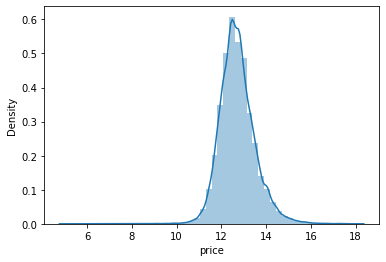

In [530]:
#inspecting the target variable
price = train["price"]
print(price.describe())
sns.distplot(np.log(price))
#skewness and kurtosis
print("Skewness: %f" % price.skew())
print("Kurtosis: %f" % price.kurt())

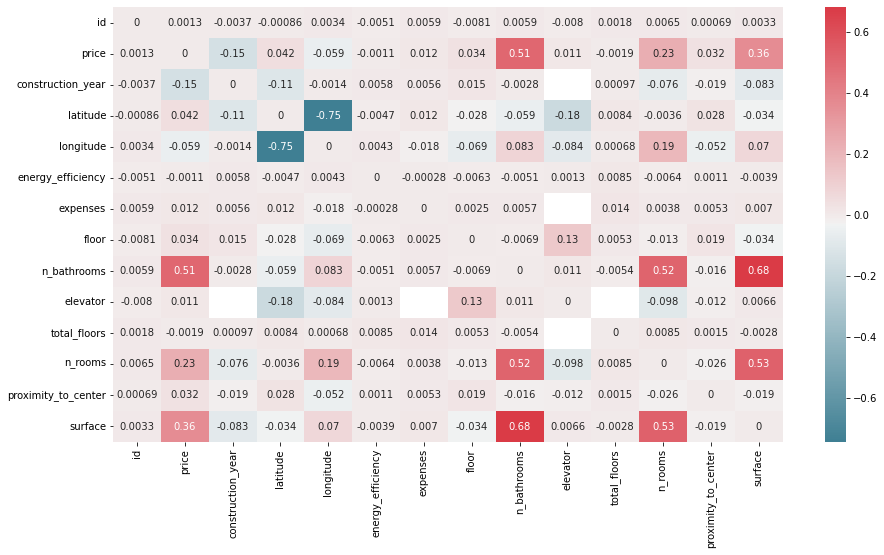

In [531]:
#check correlation between the target variable and the other variables
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corrmat-np.eye(corrmat.shape[0]), annot = True, cmap = sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

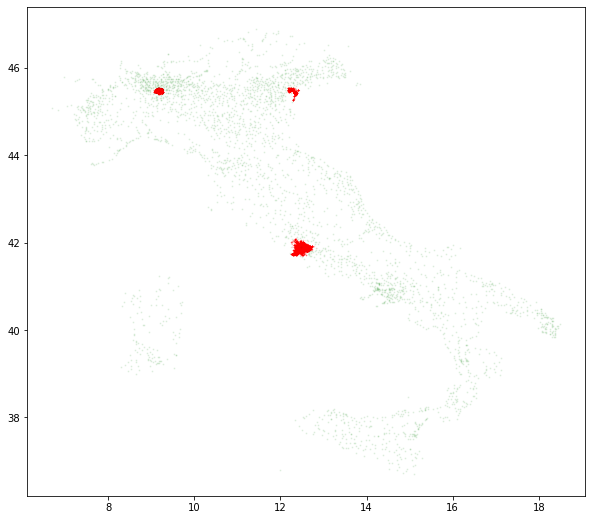

In [532]:
#get an idea of the locations of the houses
it = pd.read_csv("it.csv") #data on the coordinates of italian cities
fig, ax = plt.subplots(figsize = ((10,9)))
plt.scatter(x = it["lng"], y = it["lat"], alpha= 20/256, s = 1, c = "g")
plt.scatter(x = data["longitude"], y = data["latitude"], alpha= 20/256, s = 0.2, c="r")
plt.grid(False)
ax.set_facecolor('white')

plt.show()

# Dealing with missing values

In [533]:
#missing data
total_train = train.isnull().sum().sort_values(ascending=False)
percent_train = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
total_test = test.isnull().sum().sort_values(ascending = False)
percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_train, percent_train, total_test, percent_test], axis=1, keys=['Total_tran', 'Percent_train', "Total_test", "Percent_test"])
missing_data

,Total_tran,Percent_train,Total_test,Percent_test
garden,31529,0.680795,13443.0,0.679351
energy_efficiency,19903,0.429759,8570.0,0.433091
total_floors,18349,0.396204,7938.0,0.401152
elevator,17443,0.376641,7455.0,0.376743
expenses,16154,0.348808,6971.0,0.352284
balcony,15443,0.333456,6732.0,0.340206
construction_year,13946,0.301131,5964.0,0.301395
n_bathrooms,2416,0.052168,951.0,0.048059
floor,2031,0.043855,876.0,0.044269
conditions,1229,0.026537,511.0,0.025824


<AxesSubplot:>

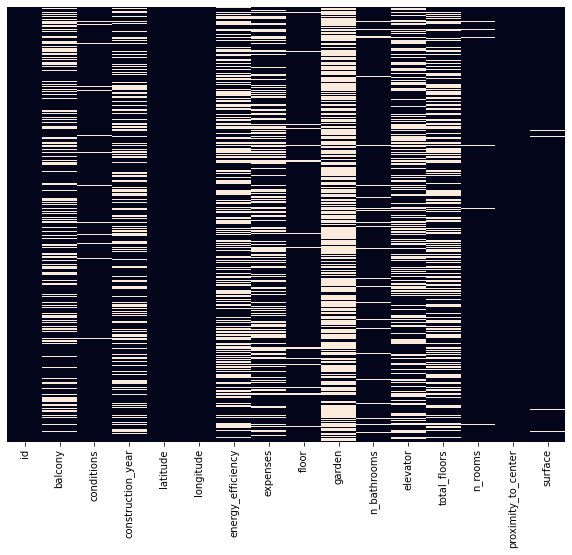

In [534]:
#graphically representing where most of the null values are
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data.isnull(), yticklabels = False, cbar = False)


### 1. Garden

In [535]:
# I will assume that if we dont have a value for the garden variable, then the house has no garden.
train["garden"].fillna(value = False, inplace = True)
# compute the correlation 
print("The correlation is: \n", train[["garden", "price"]].corr())
#since the correlation is still very low, i will drop the garden feature
train = train.drop("garden", axis = 1)
test = test.drop("garden", axis = 1)


The correlation is: 
           garden     price
garden  1.000000 -0.013846
price  -0.013846  1.000000


### 2. Energy Efficiency

In [536]:
median_imputer = SimpleImputer(strategy = "median")
# I will replace the nan values with the median and check the correlation
train[["energy_efficiency"]] = median_imputer.fit_transform(train[["energy_efficiency"]])
#compute the correlation
print("the correlation is: \n", train[["energy_efficiency", "price"]].corr())
#since the correlation is still very low, i will drop the energy_efficiency feature
train = train.drop("energy_efficiency", axis = 1)
test = test.drop("energy_efficiency", axis = 1)


the correlation is: 
                    energy_efficiency     price
energy_efficiency           1.000000 -0.000757
price                      -0.000757  1.000000


### 3. Total floors

In [537]:
# I will replace the nan values with the median and check the correlation
train[["total_floors"]] = median_imputer.fit_transform(train[["total_floors"]])
#compute the correlation
print("the correlation is: \n", train[["total_floors", "price"]].corr())
#since the correlation is still very low, i will drop the total_floors feature
train = train.drop("total_floors", axis = 1)
test = test.drop("total_floors", axis = 1)


the correlation is: 
               total_floors     price
total_floors      1.000000 -0.001606
price            -0.001606  1.000000


### 4. Elevator

In [538]:
# I will assume that if we dont have a value for the elevator variable, then the house has no elevator.
train["elevator"].fillna(value = 0.0, inplace = True)
#compute the correlation
print("the correlation is: \n", train[["elevator", "price"]].corr())
#since the correlation is still very low, i will drop the elevator feature
train = train.drop("elevator", axis = 1)
test = test.drop("elevator", axis = 1)

the correlation is: 
           elevator     price
elevator  1.000000  0.001187
price     0.001187  1.000000


### 5. Expenses

In [539]:
# I will replace the nan values with the median and check the correlation
train[["expenses"]] = median_imputer.fit_transform(train[["expenses"]])
#compute the correlation
print("the correlation is: \n", train[["expenses", "price"]].corr())
#since the correlation is still very low, i will drop the expenses feature
train = train.drop("expenses", axis = 1)
test = test.drop("expenses", axis = 1)

the correlation is: 
           expenses     price
expenses  1.000000  0.004549
price     0.004549  1.000000


### 6. Balcony

In [540]:
# I will assume that if we dont have a value for the balcony variable, then the house has no balcony.
train["balcony"].fillna(value = False, inplace = True)
# compute the correlation 
print("The correlation is: \n", train[["balcony", "price"]].corr())
#since the correlation is still very low, i will drop the garden feature
train = train.drop("balcony", axis = 1)
test = test.drop("balcony", axis = 1)

The correlation is: 
          balcony    price
balcony  1.00000 -0.00433
price   -0.00433  1.00000


### 7. Conditions

In [541]:
# i will first substitute the nan values with a fifth class and then encode the variable
train['conditions'] = train['conditions'].fillna(0)
train['conditions'] = train['conditions'].replace({'Da ristrutturare': 1, 'Buono stato / Abitabile': 2, 'Nuovo / Nuova costruzione': 3, 'Ottimo / Ristrutturato': 4 })
#to the same for the test set
test['conditions'] = test['conditions'].fillna(0)
test['conditions'] = test['conditions'].replace({'Da ristrutturare': 1, 'Buono stato / Abitabile': 2, 'Nuovo / Nuova costruzione': 3, 'Ottimo / Ristrutturato': 4 })


### 8. n_bathrooms

In [542]:
# the correlation is already strong, i will replace the nan values with the median of the variable in the train set
transformer = median_imputer.fit(train["n_bathrooms"].values.reshape(-1,1))
train[["n_bathrooms"]] = transformer.transform(train[["n_bathrooms"]])
test[["n_bathrooms"]] = transformer.transform(test[["n_bathrooms"]])

### 9. Surface

In [543]:
# the correlation is already strong, i will replace the nan values with the median of the variable in the train set
transformer = median_imputer.fit(train["surface"].values.reshape(-1,1))
train[["surface"]] = transformer.transform(train[["surface"]])
test[["surface"]] = transformer.transform(test[["surface"]])



### 10. n_rooms

In [544]:
# the correlation is already strong, i will replace the nan values with the median of the variable in the train set
transformer = median_imputer.fit(train["n_rooms"].values.reshape(-1,1))
train[["n_rooms"]] = transformer.transform(train[["n_rooms"]])
test[["n_rooms"]] = transformer.transform(test[["n_rooms"]])

### 11. Longitude

In [545]:
#in the train set, i will drop the rows that contain nan values, while in the test set I will impute the median
#in order not to lose any row
train.dropna(subset=["longitude"], inplace=True)
transformer = median_imputer.fit(train["longitude"].values.reshape(-1,1))
test[["longitude"]] = transformer.transform(test[["longitude"]])


### 12. Latitude

In [546]:
train.dropna(subset=["latitude"], inplace=True)
transformer = median_imputer.fit(train["latitude"].values.reshape(-1,1))
test[["latitude"]] = transformer.transform(test[["latitude"]])

### 13. Proximity_to_center

In [547]:
#we already removed the nans when dealing with longitude and latitude for the train set
train["proximity_to_center"].isna().sum()
#impute ones for NaNs in test set
test["proximity_to_center"] = test["proximity_to_center"].fillna(1)

In [548]:
train.head(20)

,id,price,conditions,construction_year,latitude,longitude,floor,n_bathrooms,n_rooms,proximity_to_center,surface
0,10461,60000,2,1980.0,41.901300,12.700000,2.0,1.0,1.0,1.00000,35.0
1,51304,900000,2,NaN,41.907017,12.481311,3.0,1.0,3.0,1.00000,131.0
2,33032,33000,2,1960.0,41.976500,12.440500,4.0,1.0,1.0,1.00000,16.0
3,62281,166000,4,NaN,45.484800,12.198200,1.0,1.0,2.0,0.99205,100.0
4,45681,410000,2,NaN,45.424480,12.328622,3.0,2.0,3.0,1.00000,90.0
5,59924,89000,2,NaN,41.874581,12.541382,-1.0,1.0,2.0,1.00000,30.0
6,36856,632000,2,NaN,41.864600,12.500900,2.0,3.0,4.0,1.00000,91.0
7,47960,147000,2,1960.0,45.501742,12.254337,-1.0,1.0,5.0,1.00000,107.0
8,7326,275000,4,1950.0,41.896900,12.519100,6.0,1.0,3.0,1.00000,75.0
9,44039,459000,4,1995.0,41.906400,12.420300,0.0,3.0,5.0,1.00000,130.0


### 14. Floor

In [549]:
#the correlation is already considerable. I will replace the NaN values using KNN imputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(train.drop('price',axis = 1).loc[:, :])

KNNImputer()

In [550]:
train["floor"] =  imputer.transform(train.drop('price',axis = 1).loc[:, :])[:,5]
train['floor'] = np.round(train['floor'])
test["floor"] =  imputer.transform(test.loc[:, :])[:,5]
test["floor"] = np.round(test['floor'])

In [551]:
train["floor"].value_counts()

 1.0     10441
 2.0      8364
 3.0      6353
 0.0      5950
-1.0      4927
 4.0      4384
 5.0      2694
 6.0      1452
 7.0      1058
 8.0       419
 9.0       115
 10.0       37
-2.0        29
 12.0       19
 11.0       14
 14.0        9
-3.0         8
 13.0        8
 16.0        4
 15.0        4
 18.0        2
 17.0        2
 56.0        1
 26.0        1
-4.0         1
 19.0        1
-5.0         1
 20.0        1
Name: floor, dtype: int64

### 15. Construction_year

In [552]:
train["construction_year"] = imputer.transform(train.drop('price',axis = 1).loc[:, :])[:,2]
train['construction_year'] = np.round(train['construction_year'])
test["construction_year"] = imputer.transform(test.loc[:, :])[:,2]
test["construction_year"] = np.round(test["construction_year"])


In [553]:
train["construction_year"].value_counts()

1960.0    5318
1970.0    3898
1980.0    1910
1950.0    1899
1900.0    1434
          ... 
1640.0       1
1781.0       1
2083.0       1
1782.0       1
1818.0       1
Name: construction_year, Length: 305, dtype: int64

### Check the current missing values situation after this data manipulation

In [554]:
total_train = train.isnull().sum().sort_values(ascending=False)
percent_train = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
total_test = test.isnull().sum().sort_values(ascending = False)
percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_train, percent_train, total_test, percent_test], axis=1, keys=['Total_train', 'Percent_train', "Total_test", "Percent_test"])
missing_data

,Total_train,Percent_train,Total_test,Percent_test
id,0,0.0,0.0,0.0
price,0,0.0,NaN,NaN
conditions,0,0.0,0.0,0.0
construction_year,0,0.0,0.0,0.0
latitude,0,0.0,0.0,0.0
longitude,0,0.0,0.0,0.0
floor,0,0.0,0.0,0.0
n_bathrooms,0,0.0,0.0,0.0
n_rooms,0,0.0,0.0,0.0
proximity_to_center,0,0.0,0.0,0.0


# Dealing with outliers

### Price

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

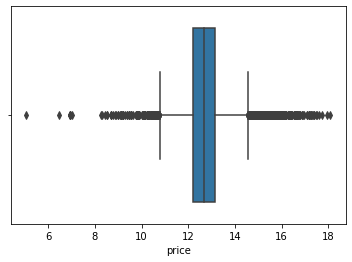

In [555]:
sns.boxplot(np.log(train["price"]))

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

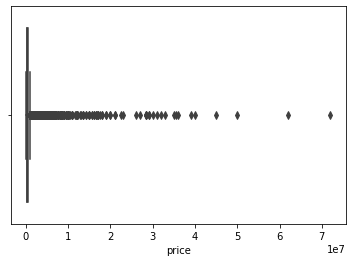

In [556]:
sns.boxplot(train["price"])

In [557]:
train = train.loc[train['price'] < 5.1e7]
train = train.loc[np.log(train['price']) > 8]

### Construction year

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='construction_year'>

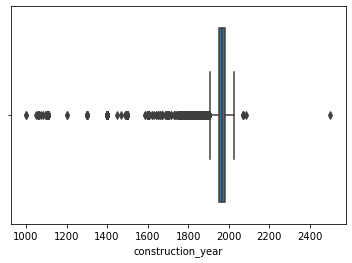

In [558]:
sns.boxplot(train["construction_year"])

In [559]:
train = train.loc[train['construction_year'] < 2200]

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='construction_year'>

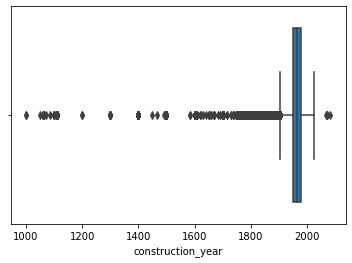

In [560]:
sns.boxplot(train["construction_year"])

# Feature engineering

In [561]:
#create a variable that indicates whether the city is in the area of Milan, Rome or Venice 
# get the coordinates of these 3 cities
cities = ["Milano", "Roma", "Venezia"]
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_app")
city_dict = {}
for i in cities:
    location = geolocator.geocode(i)
    city_dict[i]= (location.latitude, location.longitude)
    
city_dict

{'Milano': (45.4641943, 9.1896346),
 'Roma': (41.8933203, 12.4829321),
 'Venezia': (45.4371908, 12.3345898)}

In [562]:
# create a function that calculates the distance between two points 
from math import radians, sin, cos, sqrt, atan2
def distance(lat1, lon1, lat2, lon2):
    # approximate radius of Earth in km
    R = 6373.0

    # convert decimal degrees to radians
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # calculate the differences between the latitudes and longitudes
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # apply the Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance_km = (R * c) 

    return distance_km 


In [563]:
#assign a city label to each observation of the dataset
threshold = 40  # set the threshold for the distance in kilometers
coords_list_train = list(zip(train['latitude'], train['longitude']))
coords_list_test = list(zip(test['latitude'], test['longitude']))

def assign_city(coords_list, city_dict, threshold):
    result = []
    for coords in coords_list:
        for city_label, city_coords in city_dict.items():
            dist = distance(coords[0], coords[1], city_coords[0], city_coords[1])
            if dist <= threshold:
                result.append(city_label)
                break
        else:
            result.append(None)
    return result

# assign the label to the observation both for the train and the test set
train["city"] = assign_city(coords_list_train, city_dict, threshold)
test["city"] = assign_city(coords_list_test, city_dict, threshold)
#transform it into a dummy variable
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [564]:
#create a variable that calculates the distance of each house from the center of the city
#piazza del duomo milano
milan_center_lat = 45.464098
milan_center_lon = 9.191926
#piazza di spagna roma
rome_center_lat = 41.905386
rome_center_lon = 12.482542
#piazza san marco venezia
venice_center_lat = 45.433635
venice_center_lon = 12.337164

In [565]:
#calculate the distance and assign it to the row
train['distance_to_center'] = train.apply(lambda row: distance(row['latitude'], row['longitude'], milan_center_lat, milan_center_lon) if row['city_Milano'] == 1 else (
    distance(row['latitude'], row['longitude'], rome_center_lat, rome_center_lon) if row['city_Roma'] == 1 else (
    distance(row['latitude'], row['longitude'], venice_center_lat, venice_center_lon)  if row['city_Venezia'] == 1 else None)), axis=1)


In [566]:
#to the same for the test set
test['distance_to_center'] = test.apply(lambda row: distance(row['latitude'], row['longitude'], milan_center_lat, milan_center_lon) if row['city_Milano'] == 1 else (
    distance(row['latitude'], row['longitude'], rome_center_lat, rome_center_lon)  if row['city_Roma'] == 1 else (
    distance(row['latitude'], row['longitude'], venice_center_lat, venice_center_lon)  if row['city_Venezia'] == 1 else None)), axis=1)

In [567]:
train.head()

,id,price,conditions,construction_year,latitude,longitude,floor,n_bathrooms,n_rooms,proximity_to_center,surface,city_Milano,city_Roma,city_Venezia,distance_to_center
0,10461,60000,2,1980.0,41.901300,12.700000,2.0,1.0,1.0,1.00000,35.0,0,1,0,18.008060
1,51304,900000,2,1988.0,41.907017,12.481311,3.0,1.0,3.0,1.00000,131.0,0,1,0,0.208091
2,33032,33000,2,1960.0,41.976500,12.440500,4.0,1.0,1.0,1.00000,16.0,0,1,0,8.641030
3,62281,166000,4,1950.0,45.484800,12.198200,1.0,1.0,2.0,0.99205,100.0,0,0,1,12.244672
4,45681,410000,2,1976.0,45.424480,12.328622,3.0,2.0,3.0,1.00000,90.0,0,0,1,1.217213


In [568]:
# use clustering to divide the houses in different neighborhoods
#Milan
Milan_train = train[train["city_Milano"] == 1] #get the df of houses in Milan's area
pos = Milan_train[['longitude','latitude']]
kmeans = KMeans(n_clusters=14, random_state = 31) # cluster  the houses in neighbourhoods using KMeans
kmeans.fit(pos)
clusters = kmeans.predict(pos)

train['neighborhood'] = np.zeros(len(train))
train.loc[train['city_Milano']== 1 , 'neighborhood'] = clusters

#test set
Milan_test = test[test["city_Milano"] == 1]
pos = Milan_test[['longitude','latitude']]
clusters = kmeans.predict(pos)
test['neighborhood'] = np.zeros(len(test))
test.loc[test['city_Milano']== 1 , 'neighborhood'] = clusters


In [569]:
#Rome
Rome_train = train[train["city_Roma"] == 1] #get the df of houses in the Rome area
pos = Rome_train[['longitude','latitude']]
kmeans = KMeans(n_clusters= 25, random_state = 31) # cluster  the houses in neighbourhoods using KMeans
kmeans.fit(pos)
clusters = kmeans.predict(pos) + 14

train.loc[train['city_Roma']== 1 , 'neighborhood'] = clusters 

#test set
Rome_test = test[test["city_Roma"] == 1]
pos = Rome_test[['longitude','latitude']]
clusters = kmeans.predict(pos) + 14
test.loc[test['city_Roma']== 1 , 'neighborhood'] = clusters 

In [570]:
#Venice
Venice_train = train[train["city_Venezia"] == 1] #get the df of houses in the Venice area
pos = Venice_train[['longitude','latitude']]
kmeans = KMeans(n_clusters=8, random_state = 31) # cluster  the houses in neighbourhoods using KMeans
kmeans.fit(pos)
clusters = kmeans.predict(pos) + 14 + 25

train.loc[train['city_Venezia']== 1 , 'neighborhood'] = clusters 

#test set
Venice_test = test[test["city_Venezia"] == 1]
pos = Venice_test[['longitude','latitude']]
clusters = kmeans.predict(pos) + 14 + 25
test.loc[test['city_Venezia']== 1 , 'neighborhood'] = clusters 

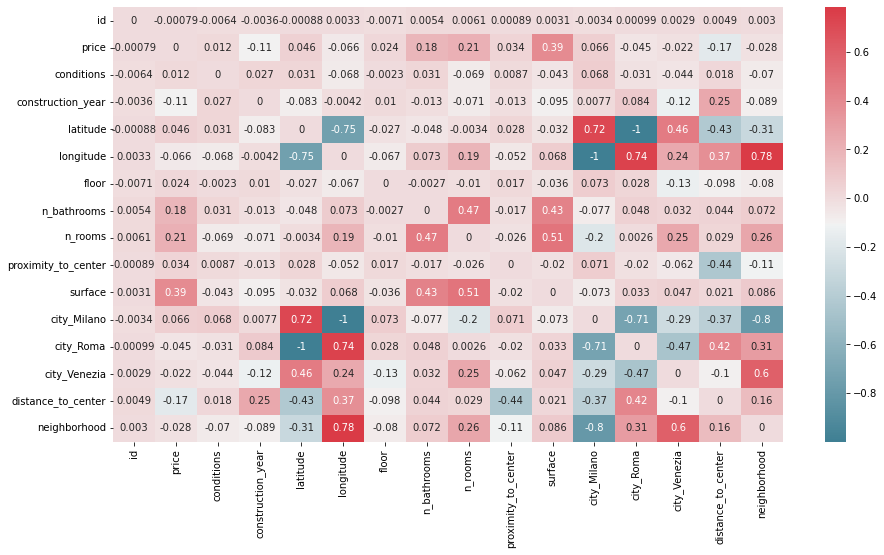

In [571]:
#check correlation between the target variable and the other variables after data manipulation
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corrmat-np.eye(corrmat.shape[0]), annot = True, cmap = sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

In [572]:
#dropping the id column as it has no relationship with the price of the house
train = train.drop("id", axis = 1)
test_no_id = test.drop("id", axis = 1)

# Modeling

In [573]:
X = train.drop("price", axis = 1)
y = train["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 27) # Split train data to test models

### Linear regression

In [574]:
train.corr()['price'].sort_values()

distance_to_center    -0.173587
construction_year     -0.107355
longitude             -0.065619
city_Roma             -0.044924
neighborhood          -0.028421
city_Venezia          -0.021683
conditions             0.012291
floor                  0.024351
proximity_to_center    0.033989
latitude               0.045888
city_Milano            0.065819
n_bathrooms            0.180537
n_rooms                0.206145
surface                0.393366
price                  1.000000
Name: price, dtype: float64

In [575]:
linreg = LinearRegression()

In [576]:
linreg.fit(X[["distance_to_center", "construction_year", "n_rooms", "n_bathrooms", "surface"]], y)
y_pred = linreg.predict(X_test[["distance_to_center", "construction_year", "n_rooms", "n_bathrooms", "surface"]])

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:0.5}")
print("R-squared: ", r2)

Mean squared error: 5.5302e+11
R-squared:  0.2739769588197297


### KNN regression

### Random forest

In [577]:
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:0.5}")
print("R-squared: ", r2)

Mean squared error: 4.4512e+11
R-squared:  0.41563111502879513


In [578]:
# Get the feature importances
importances = rfr.feature_importances_

# Sort the importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. Feature {X_train.columns[index]}: importance {importances[index]}")

Feature ranking:
1. Feature surface: importance 0.34083621963405114
2. Feature distance_to_center: importance 0.2776220067143356
3. Feature longitude: importance 0.08417549372779341
4. Feature latitude: importance 0.07856372848485127
5. Feature construction_year: importance 0.06179703953269196
6. Feature conditions: importance 0.03801565074550794
7. Feature floor: importance 0.03695943512930227
8. Feature neighborhood: importance 0.03302845632759116
9. Feature n_rooms: importance 0.028707846524634952
10. Feature n_bathrooms: importance 0.01009700569229768
11. Feature city_Venezia: importance 0.0038757433387150296
12. Feature city_Milano: importance 0.002692941620034534
13. Feature city_Roma: importance 0.0018996712639116249
14. Feature proximity_to_center: importance 0.0017287612642814872


In [579]:
# retrain the model on the whole dataset
X_train = train.drop("price", axis = 1)
y_train = train["price"]
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [581]:
#apply the model on the test_set
final_pred = rf.predict(test_no_id)
final_submission = pd.DataFrame({'id': test['id'], 'price': final_pred})
final_submission

,id,price
0,18825,1.566733e+05
1,30956,2.435433e+05
2,47193,1.131507e+06
3,27799,1.669411e+05
4,22259,1.914070e+05
...,...,...
19783,22961,6.028017e+05
19784,4606,5.551751e+05
19785,6106,2.505466e+05
19786,35370,1.311600e+05


In [582]:
final_submission.to_csv("/Users/isaachasbani/Desktop/ML challenge/submission", index = False)